# Modelling

[P10: Target Variable](#p10)

[P11: Data Preparation](#p11)

[P12: CLF Models](#p12)

[P13: Model Analysis](#p13)

In [1]:
import pandas as pd
import numpy as np
pd.set_option('max_columns', None)
import re
import seaborn as sns
sns.set(font_scale=1.5)
import matplotlib.pyplot as plt

# P10: Target Variable <a id='p10'></a>

In [361]:
feat=pd.read_csv(r'/Users/jamesgibbins/Desktop/DSI_capstone/capstone_data/features.csv')

In [371]:
model_plays=list(feat['uniqueId'])

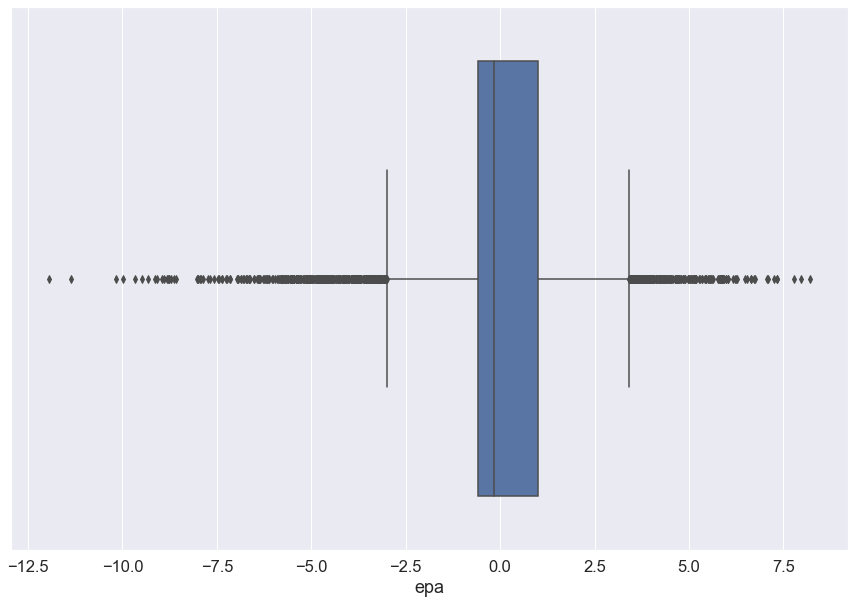

In [443]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.boxplot(plays.epa)
plt.show()

In [386]:
epa_med=plays[plays['uniqueId'].isin(model_plays)]['epa'].median()

target=plays[plays['uniqueId'].isin(model_plays)][['uniqueId','epa']].reset_index()

target['epa_cat']=['O' if target.epa[i]>= epa_med else 'D' for i in range(len(target))]

target=target[['uniqueId','epa_cat']]

In [387]:
target.epa_cat.value_counts(normalize=True)

O    0.500032
D    0.499968
Name: epa_cat, dtype: float64

In [389]:
feat=target.merge(feat, on='uniqueId')

# P10: Summary

- In order to assess the play I am using the EPA variable.
- Expected points is a metric that estimates the average of every next scoring outcome given the play's down, distance, yardline, and time remaining relative to the offensive team
- Due to the large number of outliers I am not doing a regression to try and predict the EPA for each play but rather have binarized the variable based on the median epa
- If the epa for a play is higher than the median I have classified it as a successful action for the offense, and conversely if the epa is below the median it will be succesful for the defense

# P11: Data Preparation <a id='p11'></a>

In [390]:
#features to dummify
dummy=['week','home', 'away','offenseTeam','defenseTeam','quarter', 'down',
       'offenseFormation','off_TE', 'off_WR', 'off_OL', 'off_QB', 'off_DL','off_DB',
       'typeDropback','defendersInTheBox','numberOfPassRushers',
       'def_DL', 'def_LB', 'def_DB', 'def_TE', 'def_OL', 'def_WR',
       'rec_nflId','rec_position','rec_route','passer_nflId','passer_position','def1_nflId','def1_position',
      'def2_nflId','def2_position','def3_nflId','def3_position',
       'def4_nflId','def4_position','def5_nflId','def5_position']

In [391]:
# dummifying categorical variables
X_d=pd.get_dummies(feat, columns=dummy)

In [392]:
y=X_d.pop('epa_cat')

In [396]:
# baseline of 50%
y.value_counts(normalize=True)

O    0.500032
D    0.499968
Name: epa_cat, dtype: float64

In [507]:
feat[feat['week']==7]['epa_cat'].value_counts(normalize=True)

D    0.505855
O    0.494145
Name: epa_cat, dtype: float64

In [505]:
feat[feat['week']==17]['epa_cat'].value_counts(normalize=True)

D    0.538717
O    0.461283
Name: epa_cat, dtype: float64

In [405]:
# as the target variable is quite varied between weeks (up to 53.9% favouring defensive in week 17) - I will be taking a 20% random stratified sample for the test group across all weeks - 
# rather than predicting the outcomes for the last 20% of games 

X_train, X_test, y_train, y_test = train_test_split(X_d, y,
                        stratify=y, test_size=0.2, random_state=11)

In [406]:
# standardised variables in order to compare features fairly

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X_d.columns)
X_test = pd.DataFrame(X_test, columns=X_d.columns)

# P12: CLF Models <a id='p12'></a>

In [397]:
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import svm, linear_model, datasets
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [407]:
RF = RandomForestClassifier(n_jobs=2)
RF.fit(X_train, y_train)

print('Train Score:', RF.score(X_train,y_train))

print('Test Score:', RF.score(X_test,y_test))

print('CV Score:', cross_val_score(RF, X_train, y_train, cv=5).mean())

Train Score: 1.0
Test Score: 0.6648404769577828
CV Score: 0.6658599230054943


In [414]:
model = RandomForestClassifier(random_state=30, n_jobs=2)

params = {'criterion': ['gini','entropy'],
          'n_estimators': (100,500,2000),
          'oob_score':[True,False]}
gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  cv=5,
                  scoring='accuracy',
                  return_train_score=True,
                 verbose=10)
gs.fit(X_train, y_train)
print(gs.best_estimator_)
print("Training Score:", gs.best_estimator_.score(X_train,y_train))
print("Test Score:",gs.best_estimator_.score(X_test,y_test))
score = cross_val_score(gs.best_estimator_, X_train, y_train, cv=5, n_jobs=2)
print("Mean CV:",score.mean())

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] criterion=gini, n_estimators=500, oob_score=True ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, n_estimators=500, oob_score=True, score=(train=1.000, test=0.703), total= 3.0min
[CV] criterion=gini, n_estimators=500, oob_score=True ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min remaining:    0.0s


[CV]  criterion=gini, n_estimators=500, oob_score=True, score=(train=1.000, test=0.692), total= 2.5min
[CV] criterion=gini, n_estimators=500, oob_score=True ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.6min remaining:    0.0s


[CV]  criterion=gini, n_estimators=500, oob_score=True, score=(train=1.000, test=0.678), total= 2.6min
[CV] criterion=gini, n_estimators=500, oob_score=False ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.2min remaining:    0.0s


[CV]  criterion=gini, n_estimators=500, oob_score=False, score=(train=1.000, test=0.703), total= 1.3min
[CV] criterion=gini, n_estimators=500, oob_score=False ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  9.6min remaining:    0.0s


[CV]  criterion=gini, n_estimators=500, oob_score=False, score=(train=1.000, test=0.692), total= 1.4min
[CV] criterion=gini, n_estimators=500, oob_score=False ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 11.0min remaining:    0.0s


[CV]  criterion=gini, n_estimators=500, oob_score=False, score=(train=1.000, test=0.678), total= 1.2min
[CV] criterion=gini, n_estimators=2000, oob_score=True ...............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 12.2min remaining:    0.0s


[CV]  criterion=gini, n_estimators=2000, oob_score=True, score=(train=1.000, test=0.710), total= 8.8min
[CV] criterion=gini, n_estimators=2000, oob_score=True ...............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 21.1min remaining:    0.0s


[CV]  criterion=gini, n_estimators=2000, oob_score=True, score=(train=1.000, test=0.691), total= 7.4min
[CV] criterion=gini, n_estimators=2000, oob_score=True ...............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 28.6min remaining:    0.0s


[CV]  criterion=gini, n_estimators=2000, oob_score=True, score=(train=1.000, test=0.685), total= 7.7min
[CV] criterion=gini, n_estimators=2000, oob_score=False ..............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 36.4min remaining:    0.0s


[CV]  criterion=gini, n_estimators=2000, oob_score=False, score=(train=1.000, test=0.710), total= 3.9min
[CV] criterion=gini, n_estimators=2000, oob_score=False ..............
[CV]  criterion=gini, n_estimators=2000, oob_score=False, score=(train=1.000, test=0.691), total= 3.8min
[CV] criterion=gini, n_estimators=2000, oob_score=False ..............
[CV]  criterion=gini, n_estimators=2000, oob_score=False, score=(train=1.000, test=0.685), total= 3.6min
[CV] criterion=entropy, n_estimators=500, oob_score=True .............
[CV]  criterion=entropy, n_estimators=500, oob_score=True, score=(train=1.000, test=0.705), total= 2.1min
[CV] criterion=entropy, n_estimators=500, oob_score=True .............
[CV]  criterion=entropy, n_estimators=500, oob_score=True, score=(train=1.000, test=0.692), total= 1.9min
[CV] criterion=entropy, n_estimators=500, oob_score=True .............
[CV]  criterion=entropy, n_estimators=500, oob_score=True, score=(train=1.000, test=0.686), total= 1.9min
[CV] criteri

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 88.0min finished


RandomForestClassifier(criterion='entropy', n_estimators=2000, n_jobs=2,
                       oob_score=True, random_state=30)
Training Score: 1.0
Test Score: 0.706090879793748
Mean CV: 0.6983397807865893


In [408]:
DT = DecisionTreeClassifier(max_depth=5)
DT.fit(X_train, y_train)

print("Training_Score:", DT.score(X_train, y_train))

print("Test_Score:", DT.score(X_test,y_test))

scores = cross_val_score(DT, X_train, y_train, cv=3)

print("CV Score:", scores.mean())

Training_Score: 0.6989039329464861
Test_Score: 0.6654850145020947
CV Score: 0.6764990328820115


In [410]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [411]:
bagging = BaggingClassifier(DecisionTreeClassifier(),
                            max_samples=0.5, 
                            max_features=0.5, 
                            n_estimators=100)

print("Bagging CV training score:\t", 
      cross_val_score(bagging, X_train, y_train,
                    cv=5, n_jobs=2).mean())

bagging.fit(X_train, y_train)

print("Training_Score:", bagging.score(X_train, y_train))

print("Test_Score:", bagging.score(X_test,y_test))

Bagging CV training score:	 0.7163926583371253
Training_Score: 0.9936331399097357
Test_Score: 0.7186593619078311


# P12: Summary

- A few of the top performing models are shown - all models have been run with a 5 fold cross validation to prevent the chances of over fitting
- A Gridsearch is shown for the Random Forest, improving CV score from 0.665 to 0.698
- Ultimately the best model was a bagging classifier on a Decision Tree with a 0.718 accuracy score

# P13: Model Analysis <a id='p13'></a>

In [418]:
predictions_test_bag = bagging.predict(X_test)

In [419]:
probabilities_test__bag = bagging.predict_proba(X_test)

In [420]:
print(classification_report(y_test, predictions_test_bag, digits=4))

              precision    recall  f1-score   support

           D     0.7306    0.6925    0.7110      1551
           O     0.7079    0.7448    0.7259      1552

    accuracy                         0.7187      3103
   macro avg     0.7193    0.7187    0.7185      3103
weighted avg     0.7193    0.7187    0.7185      3103



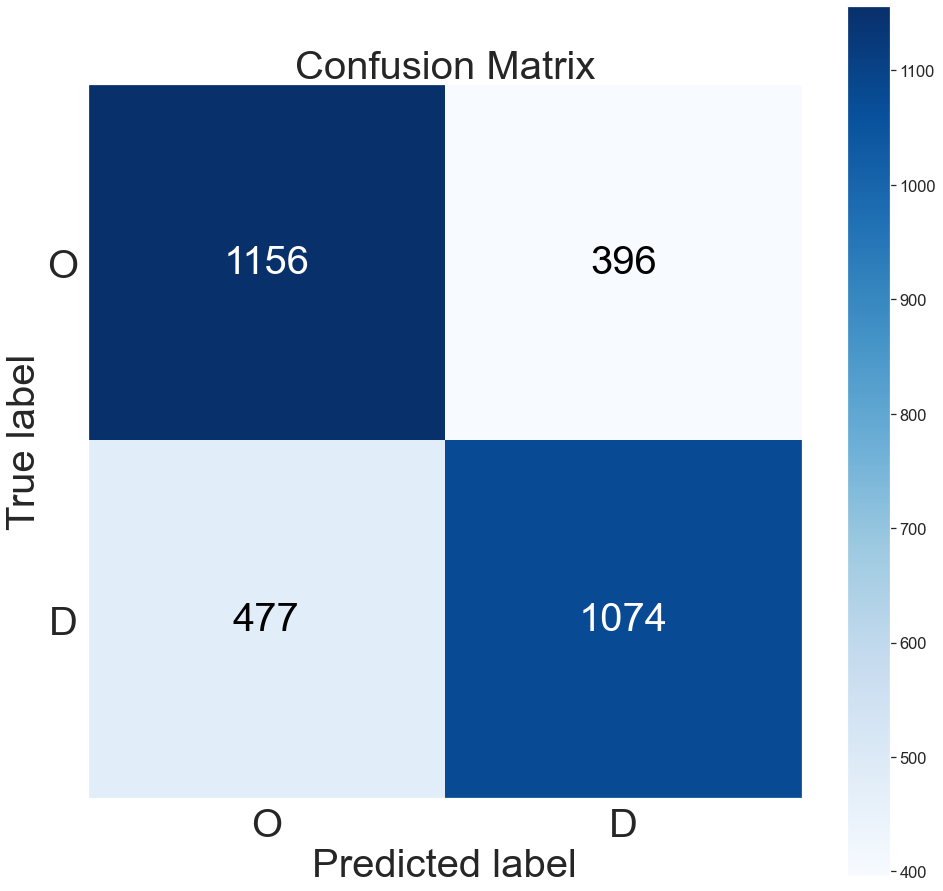

In [421]:
skplt.metrics.plot_confusion_matrix(y_test, predictions_test_bag, labels=['O','D'], text_fontsize=40,title_fontsize=40, figsize=(16, 16))
plt.show()

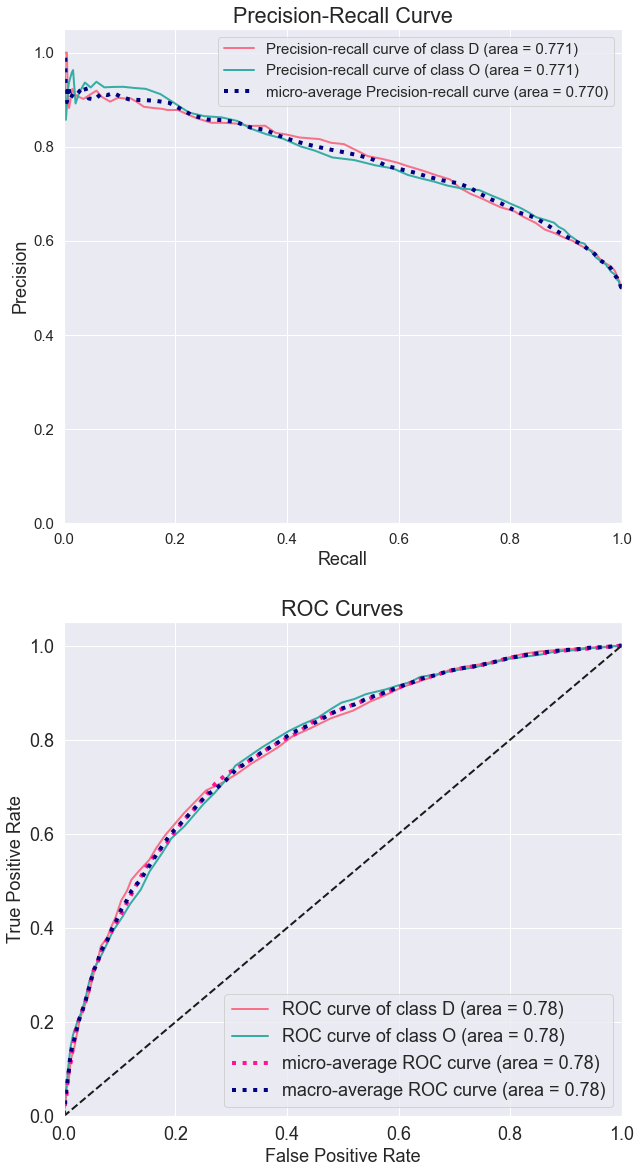

In [424]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 2))

fig, ax = plt.subplots(nrows = 2, figsize=(10, 20))

skplt.metrics.plot_precision_recall(y_test, probabilities_test__bag, cmap=cmap, ax=ax[0],
                                   text_fontsize=15, title_fontsize='large', )

skplt.metrics.plot_roc(y_test, probabilities_test__bag, cmap=cmap, ax = ax[1])

plt.show()

# P13.1: Feature Importances 

In [425]:
feat_imp=pd.DataFrame(list(zip(X_d.columns, gs.best_estimator_.feature_importances_)), 
             columns=['feature', 'importance'])\
    .sort_values(by='importance', ascending=False)

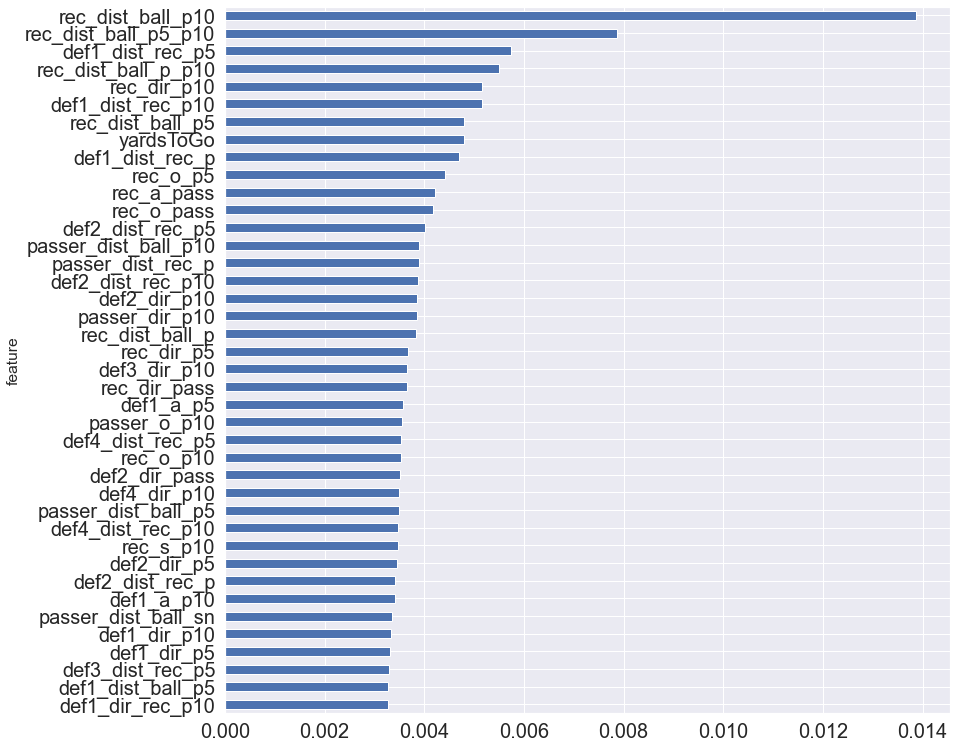

In [517]:
graph_feat=feat_imp[:40].set_index('feature')

fig, ax = plt.subplots(figsize=(13, 13))
graph_feat['importance'].sort_values().plot(kind='barh',fontsize=20);

In [430]:
feat_imp[feat_imp['feature'].str.contains('nflId')][:10]

,feature,importance
1171,passer_nflId_2533031.0,0.000138
1148,passer_nflId_2505996.0,0.000130
1145,passer_nflId_2504775.0,0.000123
1150,passer_nflId_2506109.0,0.000123
1153,passer_nflId_2506363.0,0.000120
1263,passer_nflId_2555334.0,0.000117
1114,passer_nflId_79860.0,0.000116
1325,passer_nflId_2560858.0,0.000115
1108,passer_nflId_310.0,0.000114
1151,passer_nflId_2506121.0,0.000113


In [429]:
feat_imp[(feat_imp['feature'].str.contains('defenseTeam'))][:10]

,feature,importance
485,defenseTeam_PHI,0.000131
481,defenseTeam_NO,0.000129
465,defenseTeam_CHI,0.000127
468,defenseTeam_DAL,0.000125
461,defenseTeam_ATL,0.000124
466,defenseTeam_CIN,0.000120
489,defenseTeam_TB,0.000119
467,defenseTeam_CLE,0.000119
483,defenseTeam_NYJ,0.000118
480,defenseTeam_NE,0.000118


# P13: Summary <a id='p13.2'></a>

- The bagging model was slightly better at predicting for Offense vs Defense with F1 score 0.72 vs 0.71 and recall 0.74 vs 0.69 
- Area under Precision - Recall and ROC curves was almost identical for both classes
- Engineered features dominated the feature importance of the Random Forest model, with only YardsToGo featuring in top 40
- I extracted the highest featured defence teams and players. (passers dominated here - QBs)